# **Module**: Coding Exercises
## **Toipc**: PLS-based Furnace Monitoring

In [171]:
# import required packages
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

In [172]:
#%% fetch NOC training data
data_train = pd.read_csv('NoFault_FlowVarying_48HrsData.csv').values
data_train = data_train[:,1:] # first column gives sampling time
X_train, Y_train = data_train[:,0:3], data_train[:,3:]

print('Shape of X_train matrix: ', X_train.shape)
print('Shape of Y_train matrix: ', Y_train.shape)

Shape of X_train matrix:  (2880, 3)
Shape of Y_train matrix:  (2880, 5)


In [173]:
# ==================================================================================
#       fit PLS model and generate monitoring charts for training dataset
# ==================================================================================

In [174]:
n_comp = 2

In [175]:
# scale data
X_scaler = StandardScaler()
Y_scaler = StandardScaler()
X_train_normal = X_scaler.fit_transform(X_train)
Y_train_normal = Y_scaler.fit_transform(Y_train)

pls = PLSRegression(n_components=n_comp)
pls.fit(X_train_normal, Y_train_normal)

PLSRegression()

In [176]:
# calculate T2 for training samples
Tscores_train = pls.x_scores_

score_variances = np.diag(np.var(Tscores_train, 0, ddof=1)) # ddof=1 for sample variance
score_variances_inv = np.linalg.inv(score_variances)

T2_train = np.zeros((X_train_normal.shape[0],))
for i in range(X_train_normal.shape[0]):
    T2_train[i] = np.dot(np.dot(Tscores_train[i,:], score_variances_inv), Tscores_train[i,:].T)

In [177]:
# calculate SPEx and SPEy for training samples
# SPEx
X_train_normal_reconstruct = pls.inverse_transform(Tscores_train)
x_error_train = X_train_normal - X_train_normal_reconstruct
SPEx_train = np.sum(x_error_train*x_error_train, axis = 1)

# SPEy
y_error_train = Y_train_normal - pls.predict(X_train_normal)
SPEy_train = np.sum(y_error_train*y_error_train, axis = 1)

In [178]:
# control limits
T2_CL = np.percentile(T2_train, 99)
SPEx_CL = np.percentile(SPEx_train, 99)
SPEy_CL = np.percentile(SPEy_train, 99)

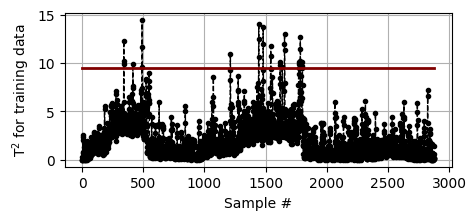

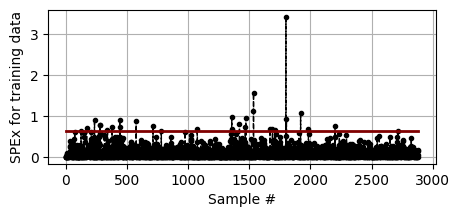

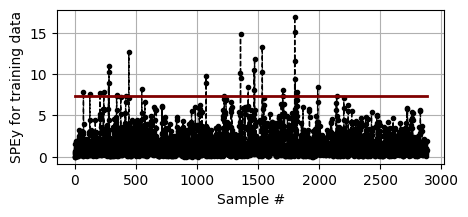

In [179]:
# control charts for training data
# T2_train
plt.figure(figsize=(5,2))
plt.plot(T2_train, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.plot([0,len(T2_train)],[T2_CL,T2_CL], color='maroon', linewidth=2)
plt.xlabel('Sample #'), plt.ylabel('T$^2$ for training data')
plt.grid()

# SPEx_train
plt.figure(figsize=(5,2))
plt.plot(SPEx_train, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.plot([0,len(SPEx_train)],[SPEx_CL,SPEx_CL], color='maroon', linewidth=2)
plt.xlabel('Sample #'), plt.ylabel('SPEx for training data')
plt.grid()

# SPEy_train
plt.figure(figsize=(5,2))
plt.plot(SPEy_train, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.plot([0,len(SPEy_train)],[SPEy_CL,SPEy_CL], color='maroon', linewidth=2)
plt.xlabel('Sample #'), plt.ylabel('SPEy for training data')
plt.grid()

plt.show()

In [180]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                  Faulty process operation analysis
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [181]:
# get test data, normalize it
data_test = pd.read_csv('TI1_DisturbanceFault_6HrsData.csv').values
data_test = data_test[:,1:] # first column gives sampling time
X_test, Y_test = data_test[:,0:3], data_test[:,3:]

print('Shape of X_test matrix: ', X_test.shape)
print('Shape of Y_test matrix: ', Y_test.shape)

X_test_normal = X_scaler.transform(X_test)
Y_test_normal = Y_scaler.transform(Y_test)

Shape of X_test matrix:  (360, 3)
Shape of Y_test matrix:  (360, 5)


In [182]:
# get scores and model predictions 
Tscores_test = pls.transform(X_test_normal)
X_test_normal_reconstruct = pls.inverse_transform(Tscores_test)
Y_test_normal_pred = pls.predict(X_test_normal)

In [183]:
# compute monitoring statistics
T2_test = np.zeros((X_test_normal.shape[0],))
for i in range(X_test_normal.shape[0]):
    T2_test[i] = np.dot(np.dot(Tscores_test[i,:], score_variances_inv), Tscores_test[i,:].T)

x_error_test = X_test_normal - X_test_normal_reconstruct
SPEx_test = np.sum(x_error_test*x_error_test, axis = 1)

y_error_test = Y_test_normal - Y_test_normal_pred
SPEy_test = np.sum(y_error_test*y_error_test, axis = 1)

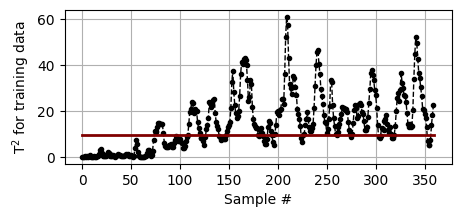

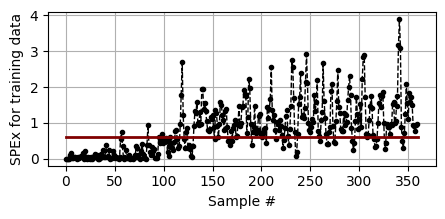

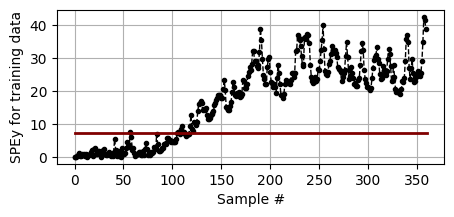

In [184]:
# plot control charts for the complete dataset
plt.figure(figsize=(5,2))
plt.plot(T2_test, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.plot([0,len(T2_test)],[T2_CL,T2_CL], color='maroon', linewidth=2)
plt.xlabel('Sample #'), plt.ylabel('T$^2$ for training data')
plt.grid()

plt.figure(figsize=(5,2))
plt.plot(SPEx_test, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.plot([0,len(SPEx_test)],[SPEx_CL,SPEx_CL], color='maroon', linewidth=2)
plt.xlabel('Sample #'), plt.ylabel('SPEx for training data')
plt.grid()

plt.figure(figsize=(5,2))
plt.plot(SPEy_test, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.plot([0,len(SPEy_test)],[SPEy_CL,SPEy_CL], color='maroon', linewidth=2)
plt.xlabel('Sample #'), plt.ylabel('SPEy for training data')
plt.grid()

plt.show()

In [185]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                  fault isolation by contribution plots
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [186]:
sample = 250

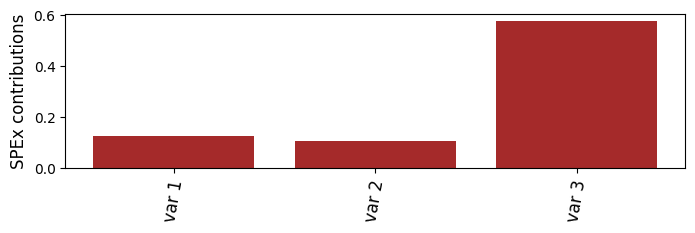

In [187]:
# SPEx contribution plot
x_error_test_sample = x_error_test[sample-1,]
SPEx_contri = x_error_test_sample*x_error_test_sample # vector of contributions

plt.figure(figsize=[8,2])
plt.bar(['var ' + str((i+1)) for i in range(len(SPEx_contri))], SPEx_contri, color='brown')
plt.xticks(rotation = 80, fontsize=12)
plt.ylabel('SPEx contributions', fontsize=12)
plt.show()

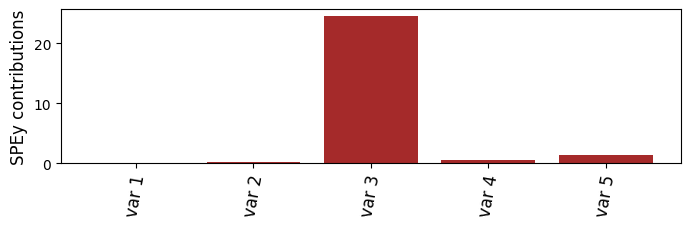

In [188]:
# SPEy contribution plot
y_error_sample = y_error_test[sample-1,]
SPEy_contri = y_error_sample*y_error_sample # vector of contributions

plt.figure(figsize=[8,2])
plt.bar(['var ' + str((i+1)) for i in range(len(SPEy_contri))], SPEy_contri, color='brown')
plt.xticks(rotation = 80, fontsize=12)
plt.ylabel('SPEy contributions', fontsize=12)
plt.show()

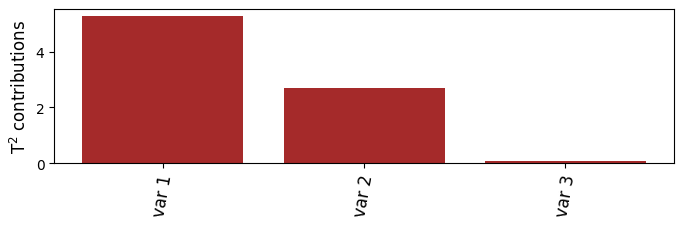

In [189]:
# T2 contribution plot
import scipy

R = pls.x_rotations_
Ghe = np.dot(scipy.linalg.sqrtm(score_variances_inv), R.T)
x_test_normal_sample = np.transpose(X_test_normal[sample-1,:])

T2_contri = np.zeros((X_test_normal.shape[1],))
for i in range(X_test_normal.shape[1]):
    vect = Ghe[:,i]*x_test_normal_sample[i]
    T2_contri[i] = np.dot(vect, vect)

plt.figure(figsize=[8,2])
plt.bar(['var ' + str((i+1)) for i in range(len(T2_contri))], T2_contri, color='brown')
plt.xticks(rotation = 80, fontsize=12)
plt.ylabel('T$^2$ contributions', fontsize=12)
plt.show()

#### The contribution plots do not seem to provide a conclusive picture of which variables are faulty. T2 contribution plot correctly captures that FC1 and FC2 are behaving ususually. SPEy contributions also correctly try to highlight DT variable which has been impacted due to sharply different values of TI1 and TI2. Due the actions of MPC, the impact of disturbance has been spread onto multiple variables (all three input variables have been impacted)! 